In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.stats import variation

## To do:

- find error on SIR and fix 
- Try writing model as SDEs 
- do SEIR on standard 
- take the variance of each year (can do this as constant parameters for each year) and then find the mean of these over the simulations 
- variance between infectious individuals per day - but its not per day - what am I calculating variance of? -- total number of individuals infectious at each given time 

- ODEs can only model decrease in epsilon and not initial conditions 
- ergodic: same behavior averaged over time as averaged over the space of all the system's states (ensemble average vs time average) -- assumes stationary (at steady state) which might not be true 
- write in report about steady state and ergodic behaviour
- might take a truncated distribution of exposed individuals, same mean as predicted but with a tail
- compare decreasing epsilon and beta -- talk about interventions, some stats and whether control teams should focus on the bats or the humans
- Write up parametre fitting properly: read hollingsworth case study + ben

# Variance of Fluctuations
From expansion of the master equations we get the FPE. Explains the macroscopic behaviour with the fluctuations around the mean. 

Compare this to numerical solutions - simulate the system multiple times and plot the variance between these simulations at each time point. 

In [128]:
def gillespieSEIR(initial, beta0,mu1, mu2, sigma, epsilon,mu, p, max_time):
    T = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    T.append(0)
    t = 0
    ind = 0
    while t <max_time:
        betat = (1-p*t)*beta0
#         betat = beta0
#         epsilont = np.maximum((1-p*t)*epsilon,0)
#         print(epsilont)
#         print(betat)
#         print(epsilon, beta0)
        state = np.zeros(shape= (4,8))
        Rse = betat*(pop[ind][0])*(pop[ind][2])/N
        state[:,0] = [-1, 1, 0,0]
        
        Rse1 = epsilon*(pop[ind][0])
        state[:,1] = [-1,1,0,0]
        
        Rei = sigma*(pop[ind][1])
        state[:,2] = [0,-1,1,0]
        
        Rir = mu2*(pop[ind][2])
        state[:,3] = [0,0, -1,1]
        
        Ris = mu1*(pop[ind][2])
        state[:,4] = [1, 0,-1,0]
        
        Rid = mu*(pop[ind][2])
        state[:,5] = [1,0, -1, 0]
        
        Red = mu*(pop[ind][1])
        state[:,6] = [1,-1,0,0]
        
        Rsb = mu*(pop[ind][3])
        state[:,7] = [1, 0, 0, -1]
        
        rate = [Rse, Rse1, Rei, Rir, Ris, Rid, Red, Rsb]
        Rtotal = sum(rate)
        if Rtotal >0:
            delta_t= -np.log(np.random.uniform(0,1))/Rtotal

            P = np.random.uniform(0,1)*Rtotal
            t =t+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            T.append(t)
            pop.append(pop[ind]+state[:,event])
        else: 
            t = max_time
#             year = year +1 
#             events.append(-1)
            T.append(t)
            pop.append(pop[ind])
        ind=ind+1
    return T, np.array(pop)

In [129]:
def gillsteps(G):
    t = G[0]
    s = G[1][:,0]
    e = G[1][:,1]
    i = G[1][:,2]
    r = G[1][:,3]
    stept = []
    steps = []
    stepe = []
    stepi = []
    stepr = []
    for ind, x in enumerate(t):
        if ind<len(t)-1:
            steps.append((s[ind], s[ind]))
            stepi.append((i[ind], i[ind]))
            stepr.append((r[ind], r[ind]))
            stepe.append((e[ind], e[ind]))
            stept.append((t[ind], t[ind+1]))
        else:
            steps.append((s[ind], s[ind]))
            stepi.append((i[ind], i[ind]))
            stepe.append((e[ind], e[ind]))
            stept.append((t[ind], t[ind]))
            stepr.append((r[ind], r[ind]))

    steps = np.array(steps).flatten()
    stepi = np.array(stepi).flatten()
    stepr = np.array(stepr).flatten()
    stept = np.array(stept).flatten()
    stepe = np.array(stepe).flatten()
    return stept, steps,stepe, stepi, stepr

In [130]:
# plt.plot(inter_t, inter_inf)
# plt.plot()
β_0 =2
μ1 = 0.1
μ2 = 0.05
σ = 0.1
# ϵ_0= 0.0001
ϵ_0 = 0
# β = 1
p=1/500
# T = 50
γ = 0.1
μ = 0.02
A = np.matrix([[-β_0 - μ, -β_0],[β_0, β_0 - μ - γ]])
print(A)
A.transpose()
T= 500

[[-2.02 -2.  ]
 [ 2.    1.88]]


In [131]:
def dbydt(X,t, b, e, m1, m2, m, s):
    x0 = -b*X[0]*X[2]- e*X[0] + m1*X[2] + m*(1-X[0])
    x1 = b*X[2]*X[0] + e*X[0] -s*X[1] - m*X[1]
    x2 = s*X[1] - X[2]*(m+m1+m2)
    return [x0,x1,x2]
ts = np.linspace(0, 500, 1000)
Z = odeint(dbydt, [0.2,0,0.8], ts, args = (β_0,ϵ_0, μ1,μ2, μ, σ ))

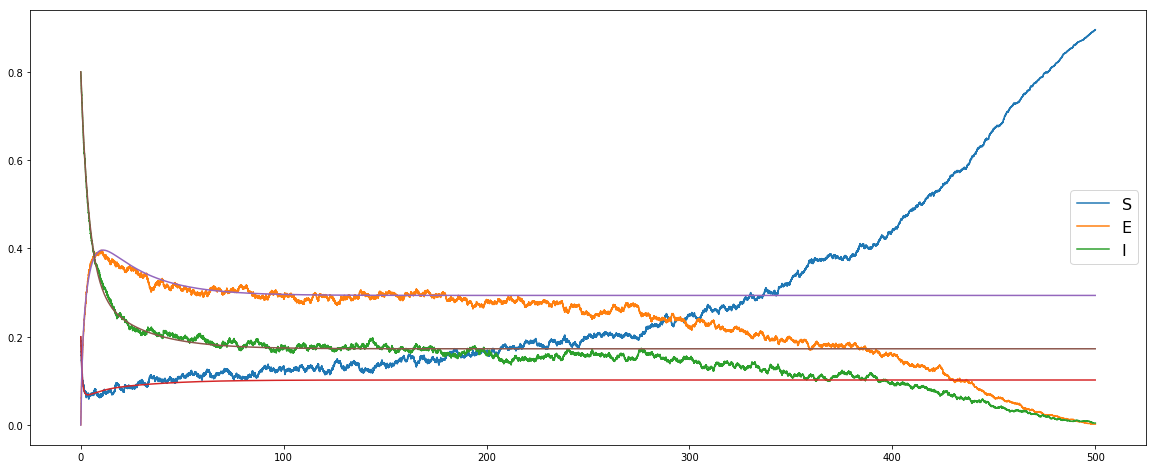

In [132]:
N = 2000
# (initial, beta0,mu1, mu2, sigma, epsilon,mu, p, max_time
G = gillespieSEIR([N*0.2,0,N*0.8,0], β_0,μ1, μ2, σ, ϵ_0,μ,p, T)


plt.figure(figsize = (20,8))
plt.plot(gillsteps(G)[0], gillsteps(G)[1]/N, label = 'S')
plt.plot(gillsteps(G)[0], gillsteps(G)[2]/N, label = 'E')
plt.plot(gillsteps(G)[0], gillsteps(G)[3]/N, label = 'I')
plt.plot(ts, Z[:,0])
plt.plot(ts, Z[:,1])
plt.plot(ts, Z[:,2])
# plt.xlim([0,100])
plt.legend(fontsize = 16)

In [133]:
inter_t = np.arange(0, round(max(gillsteps(G)[0])) +1 , 1) #interpolate to daily steps
inter_inf = np.interp(inter_t, gillsteps(G)[0],gillsteps(G)[3])

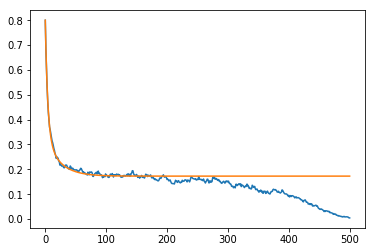

In [134]:
plt.plot(inter_t, inter_inf/N)
plt.plot(ts, Z[:,2])

In [135]:
T = 500
SIM = 50
simulations = np.zeros(shape=(SIM, T))
for k in range(SIM):
    print(k)
    G = gillespieSEIR([0.2*N,0,0.8*N, 0], β_0,μ1, μ2, σ, ϵ_0, μ, p, T)
    inter_t = np.arange(0, round(max(gillsteps(G)[0])) +1 , 1) #interpolate to daily steps
    inter_inf = np.interp(inter_t, gillsteps(G)[0],gillsteps(G)[3])
    if round(max(gillsteps(G)[0]))<T:
        simulations[k,: ] =  np.concatenate([inter_inf,np.zeros(T - len(inter_inf))])
    else:
        simulations[k,:] = inter_inf[:T]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [143]:
def covariance(X,t):
    beta = β_0*(1-p*t)
#     beta = β_0
#     epsilon = ϵ_0*(1-p*t)
    epsilon = ϵ_0
    X0_ψ = -beta*X[0]*X[2] -epsilon*X[0] + μ1*X[2]+μ*(1-X[0])
    X1_ω = beta*X[0]*X[2] + epsilon*X[0] - σ*X[1]-μ*X[1]
    X2_ϕ = σ*X[1] - X[2]*(μ1 + μ2 + μ)
    A= np.matrix([[-beta*X[2]-epsilon - μ, 0, μ1 - beta*X[0]], 
                  [beta*X[2] + epsilon, -μ-σ*X[1], beta*X[0]], 
                  [0, σ*X[1], -μ-μ1-μ2]])
    B = np.matrix([[beta*X[2]*X[0] + epsilon*X[0]+μ*(1-X[0]) + μ1*X[2], -(beta*X[0]*X[2] +epsilon*X[0]+μ*X[1]), -(μ +μ1)*X[2]]
                   ,[-(beta*X[0]*X[2] +epsilon*X[0]+μ*X[1]), beta*X[0]*X[2]+μ*X[1]+epsilon*X[0]+σ*X[1], -σ*X[1]],
                  [-(μ+μ1)*X[2], σ*X[1], X[2]*(μ+μ1+μ2)+σ*X[1]]])
    Θ = np.matrix([[X[3], X[4], X[5]],[X[4],X[6], X[7]],[X[5], X[7], X[8]]])
#     print(A)
    K = A*Θ +Θ*A.transpose()+B
    return [X0_ψ,X1_ω, X2_ϕ, K[0,0], K[0,1], K[0,2], K[1,1], K[1,2], K[2,2]]

In [144]:
# print(β_0, p, γ, μ)
β_0
T= 500
β_0

2

In [145]:


ts = np.linspace(0, T, 1000)
P = odeint(covariance, [0.2,0,0.8, 0 , 0,0,0,0,0], ts)
time = np.arange(0, 500, 1)
varI= np.interp(time, ts, P[:,8] )
meanI = np.interp(time, ts, P[:,2])
# meanI

In [146]:
t_star = (1/p)*(1- ((μ+σ)*(μ+μ1+μ2)/(β_0*σ)))
print(t_star)
simulations[0:k,:]

((np.sqrt(P[:,8]/N))/P[:,2])[2:]
β_0
print(ϵ_0)

449.0
0


In [147]:
def Qc(Bb, Ee):
    if Ee == 0:
        s = ((σ + μ)*(μ+μ1+μ2)/(σ*Bb))
        i = (μ*(1-s))/(Bb*s - μ1)
        e = i*(μ1+μ2+μ)/σ
        
    else:
        A = -(Bb/σ)*(σ+μ)*(μ+μ1+μ2)+μ1*Bb
        B = (Ee*μ1+μ*Bb - (σ + μ)*(μ+μ1+μ2)*((μ+Ee)/σ))
        C = μ*Ee
#         i = 0
    #     print((-B+np.sqrt(B**2-4*A*C))/(2*A),(-B-np.sqrt(B**2-4*A*C))/(2*A) )
        if (-B-np.sqrt(B**2 - 4*A*C))/(2*A) >=0:
#             print('yes')
            i = (-B-np.sqrt(B**2 - 4*A*C))/(2*A)
        if (-B+np.sqrt(B**2 - 4*A*C))/(2*A) >= 0:
#             print('no')
            i = (-B+np.sqrt(B**2 - 4*A*C))/(2*A)

        s = (((σ+μ)/σ)*(μ1+μ2+μ)*i)/(Bb*i + Ee)
        e = (i/σ)*(μ1 + μ2 + μ)
    
    return [s, e, i]

In [148]:
Qc(0.6,ϵ_0)


[0.34, 0.2157692307692307, 0.1269230769230769]

In [149]:
def integrand(x, a0,a1,a2, deta, ta, tc):
    return (a0 +a1*(x**2) + a2*(x**4))/((deta-(x**2)*ta)**2 + (x**2)*((tc+(x**2))**2))
from scipy.integrate import quad

In [150]:
quasi = []
quasi2 = []
quasi_cov = []
Q = []
m = []
for k in range(T):
#     b = β_0*(1-p*k)
    b = β_0
    eps = ϵ_0
    #####fixed points #####

    [star0, star1, star2] = Qc(b, eps)
    m.append(star2)
    ##### matrices A and B ######
    A= np.matrix([[-b*star2-eps - μ, 0, μ1 - b*star0], 
                  [b*star2 + eps, -μ-σ*star1, b*star0], 
                  [0, σ*star1, -μ-μ1-μ2]])
    B = np.matrix([[b*star2*star0 + eps*star0+μ*(1-star0) + μ1*star2, -(b*star0*star2 +eps*star0+μ*star1), -(μ +μ1)*star2]
                   ,[-(b*star0*star2 +eps*star0+μ*star1), b*star0*star2+μ*star1+eps*star0+σ*star1, -σ*star1],
                  [-(μ+μ1)*star2, σ*star1, star2*(μ+μ1+μ2)+σ*star1]])
    det = np.linalg.det(A)
    C= np.linalg.inv(A)*(det*np.identity(3))
#     alph = (A[1,0]**2)*B[0,0] -2*A[0,0]*A[1,0]*B[1,0] +(A[0,0]**2)*B[1,1]
    alpha0 = (B[0,0]*(C[2,0]**2)+B[1,1]*(C[2,1]**2) + B[2,2]*(C[2,2]**2)+
            2*(C[2,0]*C[2,1]*B[0,1] + C[2,0]*C[2,2]*B[0,2] + C[2,1]*C[2,2]*B[1,2]))
    alpha1 = ((A[2,0]**2)*B[0,0] + 2*A[2,0]*A[2,1]*B[0,1] - 2*(C[2,0] + (A[0,0]+A[1,1])*A[2,0])*B[0,2] +
             (A[2,1]**2)*B[1,1] - 2*(C[2,1] +A[2,1]*(A[0,0] + A[1,1]))*B[1,2] +
             ((A[0,0] + A[1,1])**2 -2*C[2,2])*B[2,2])
    alpha2 = B[2,2]
#     det = np.linalg.det(A)
    tra = np.trace(A)
    trc = np.trace(C)
    ######### Integration #########
#     print(star0)
    S = (1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[0]
    print((1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[1])
    quasi.append(S/N)
    quasi_cov.append(np.sqrt(S/N)/star2)

1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.539546039

1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.5395460396779766e-12
1.539546039

In [151]:
q= np.interp(time, ts, quasi )
len(q)

ValueError: fp and xp are not of the same length.

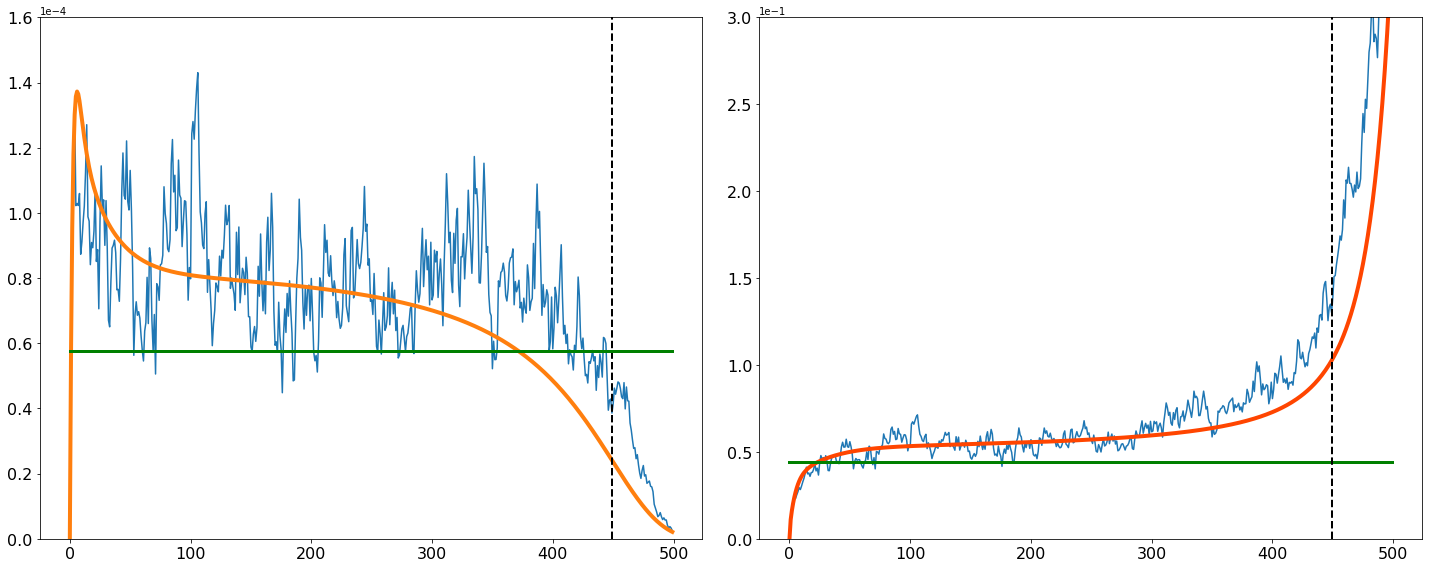

In [152]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(range(T), np.var(simulations/N, axis = 0), label = 'Simulations')
plt.plot(range(T), varI/N, linewidth =4, label = 'Variance') 
plt.plot([t_star, t_star], [0, 0.0002], '--',c='k', linewidth = 2, label = '$R_0 = 1$')
plt.plot(range(T), np.maximum(quasi,0),c = 'green', linewidth = 3)
plt.ylim([0,0.00016])
# plt.plot(ts, -Q[:,3], label = '2nd')
# plt.plot(ts, (np.sqrt(P[:,8])/P[:,2]))
# plt.legend(loc = 'upper left',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
# plt.ylim([0,2e-4])
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.subplot(1,2,2)
plt.plot(range(T), variation(simulations[:,0:500]/N, axis = 0))
plt.plot(range(T), (np.sqrt(varI/N)/meanI), linewidth = 4, c = 'orangered', label = 'Coefficent of variation') 

plt.plot(range(T), quasi_cov,linewidth = 3, c='green')

plt.plot([t_star, t_star], [0, 0.4], '--', c='k', linewidth = 2)
# plt.plot(range(T), quasi_cov,linewidth = 3, c='green')

# plt.plot(ts, -Q[:,3], label = '2nd')
plt.ylim([0,0.3])
# plt.plot(ts, (np.sqrt(P[:,8])/P[:,2]))
# plt.legend(fontsize =20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
# plt.xlim([0,100])
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

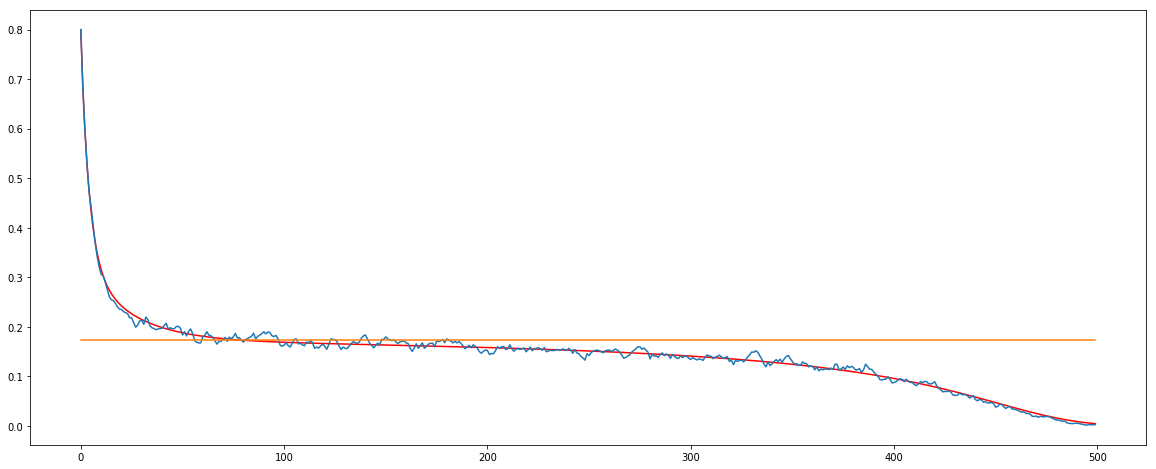

In [153]:
plt.figure(figsize = (20,8))
plt.plot(range(500),meanI, c='red')
plt.plot(range(500), (simulations/N)[1])
plt.plot(range(500), np.maximum(m,0))
# plt.plot(range(T), np.sqrt(np.maximum(np.array(quasi),0)), linewidth = 3)
# plt.plot(range(T), np.std(simulations/N, axis = 0))
# np.sqrt(varI/N)/meanI

In [236]:
# plt.plot(range(T), np.sqrt(varI/N))
# plt.plot(range(T), np.std(simulations/N, axis = 0))
quasi

[5.773850439760272e-05,
 5.7720952890675406e-05,
 5.770336891244124e-05,
 5.768575230547824e-05,
 5.7668102910967506e-05,
 5.765042056867682e-05,
 5.7632705116943634e-05,
 5.7614956392658226e-05,
 5.7597174231246026e-05,
 5.757935846665048e-05,
 5.756150893131518e-05,
 5.754362545616561e-05,
 5.752570787059087e-05,
 5.750775600242544e-05,
 5.7489769677929983e-05,
 5.747174872177239e-05,
 5.745369295700835e-05,
 5.7435602205061853e-05,
 5.7417476285704875e-05,
 5.739931501703765e-05,
 5.738111821546791e-05,
 5.7362885695689815e-05,
 5.73446172706632e-05,
 5.732631275159194e-05,
 5.7307971947902335e-05,
 5.7289594667221024e-05,
 5.727118071535226e-05,
 5.7252729896255754e-05,
 5.723424201202326e-05,
 5.7215716862855115e-05,
 5.7197154247036837e-05,
 5.717855396091468e-05,
 5.7159915798871334e-05,
 5.7141239553301126e-05,
 5.712252501458479e-05,
 5.710377197106392e-05,
 5.708498020901501e-05,
 5.706614951262308e-05,
 5.7047279663955e-05,
 5.702837044293233e-05,
 5.700942162730365e-05,
 5.

In [ ]:

plt.plot(range(T), variation(simulations[:,0:500]/N, axis = 0), label = 'Numerical simulations')
plt.plot(ts, np.sqrt(P[:,8]/N)/P[:,2], label = 'Variance') 
plt.plot([t_star, t_star], [0, 18], '--', label = '$R_0 = 1$')
# plt.plot(ts, -Q[:,3], label = '2nd')
# plt.plot(ts, (np.sqrt(P[:,8])/P[:,2]))
plt.legend()
plt.tight_layout()
# plt.xlim([0,100])
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

# Parameters the same as model


In [161]:
θ_new = np.load('../ABC/ABC_season/theta_new_F04_prior.npy')#ɛ>0
maxtol_new = len(θ_new)-1
dim_new = len(θ_new[0])
a_β, loc_β, scale_β = stats.gamma.fit(θ_new[maxtol_new][:,0])
a_ϵ, loc_ϵ, scale_ϵ = stats.gamma.fit(θ_new[maxtol_new][:,1])
a_σ, loc_σ, scale_σ = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,2]])
a_μ1, loc_μ1, scale_μ1 = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,3]])
a_μ2, loc_μ2, scale_μ2 = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,4]])

β_0 = stats.gamma.rvs( a_β, loc_β, scale_β)
μ1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
μ2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
σ = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
ϵ_0 = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)

random_E = np.random.randint(0,dim_new-1)
exposed = θ_new[maxtol_new][:,5][random_E]
# birth = 1/(67*365)
μ = 1/(67*365)
# print(birth, μ)

In [162]:
N = 1501

In [163]:
def gillespieSEIR_season_exposed(E, b, mu1,mu2,mu,p, sigma,epsilon):
    initial = [1500-E, E, 1,0]
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(1)
    events = []
    num_external= E
    num_internal = 0
    Rtotal = 1
    death = 0
    while Rtotal>0:
#         print(times)
        state = np.zeros(shape= (4,12))
        if (120 >=times >= 0):
#                 print('start', years)
            eps = epsilon*(1-p*times)
        if (365>times > 120):
#                 print('end', years)
#             times = 120
            eps = 0


#         print(times)
        if (times>=365):
            print(times)
            break
        state = np.zeros(shape= (4,12))
#         beta = np.maximum(b*(1-p*times),0)
        beta = b
#         print(beta)
#         beta = b
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        R_external = eps*pop[ind][0]
        state[:,0] = [-1,1,0,0]
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N  
        state[:,1] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,2] = [0, -1, 1, 0]
        
        
        R_ir = mu2*pop[ind][2]
        state[:,3] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,4] = [1,0,-1,0]
        
        R_ed = mu*pop[ind][1]
        state[:,5] = [1,-1,0,0]
        
        R_id = mu*pop[ind][2]
        state[:,6] = [1,0,-1,0]
        
        R_sb = mu*(pop[ind][3])
        state[:,7] = [1,0,0,-1]
        
#         R_sd = mu*pop[ind][0]
#         state[:,8] = [-1,0,0,0]

########################## RATES ##############################
        rate = [R_external, R_se, R_ei,  R_ir,  R_is, R_ed, R_id, R_sb]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
            if event == 0:
                num_external +=1
            if event == 1:
                num_internal +=1
            if event == 3:
                death +=1 
            if event == 2:
                cuminf.append(1 +cuminf[ind] )
            else:
                cuminf.append(0 +cuminf[ind])
            ind=ind+1
        N = sum(pop[ind][:2])
        if (times>=365):
#             print(times)
            break
    return event_time, np.array(pop), events, cuminf, num_external, num_internal, death, E

In [164]:
def gillstepsE(G):
    t = G[0][:-1]
    s = G[1][:,0][:-1]
    e = G[1][:,1][:-1]
    i = G[1][:,2][:-1]
    r = G[1][:,3][:-1]
    stept = []
    steps = []
    stepe = []
    stepi = []
    stepr = []
    for ind, x in enumerate(t):
        if ind<len(t)-1:
            steps.append((s[ind], s[ind]))
            stepi.append((i[ind], i[ind]))
            stepr.append((r[ind], r[ind]))
            stepe.append((e[ind], e[ind]))
            stept.append((t[ind], t[ind+1]))
        else:
            steps.append((s[ind], s[ind]))
            stepi.append((i[ind], i[ind]))
            stepe.append((e[ind], e[ind]))
            stept.append((t[ind], t[ind]))
            stepr.append((r[ind], r[ind]))

    steps = np.array(steps).flatten()
    stepi = np.array(stepi).flatten()
    stepr = np.array(stepr).flatten()
    stept = np.array(stept).flatten()
    stepe = np.array(stepe).flatten()
    return stept, steps,stepe, stepi, stepr

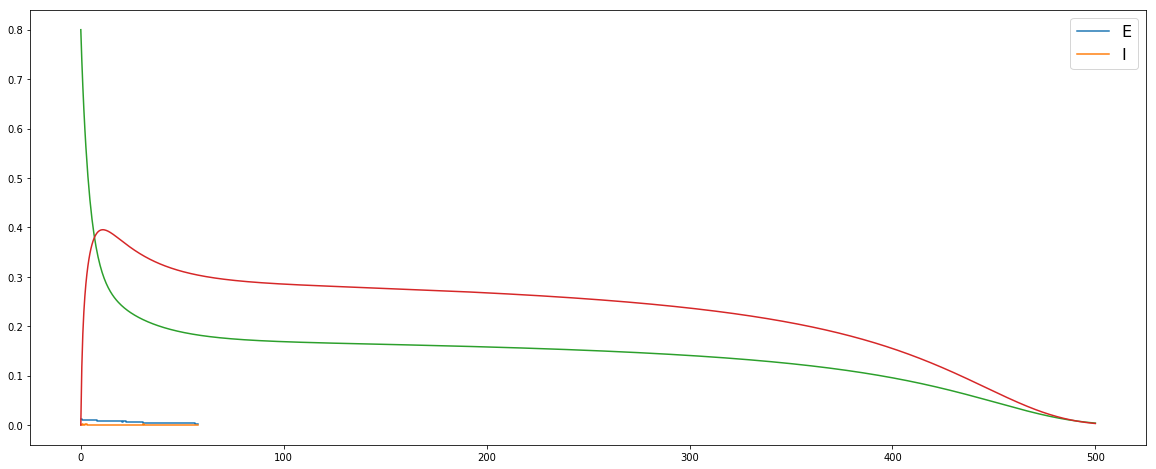

In [165]:
# N = 2000
p = 1/15
# (initial, beta0,mu1, mu2, sigma, epsilon, gamma,mu, p, max_time
G = gillespieSEIR_season_exposed(exposed, β_0,μ1, μ2, μ, p,σ, ϵ_0)


plt.figure(figsize = (20,8))
# plt.plot(gillsteps(G)[0], gillsteps(G)[1]/N, label = 'S')
plt.plot(gillstepsE(G)[0], gillstepsE(G)[2]/N, label = 'E')
plt.plot(gillstepsE(G)[0][:-1], gillstepsE(G)[3][:-1]/N, label = 'I')
plt.plot(ts, P[:,2])
plt.plot(ts, P[:,1])
# plt.xlim([0,200])
plt.legend(fontsize = 16)

In [166]:
1/p

15.0

In [167]:
T = 150
SIM = 300
simulations = np.zeros(shape=(SIM, T))
for k in range(SIM):
    print(k)
    
#     random_E = np.random.randint(0,dim_new-1)
#     exposed = θ_new[maxtol_new][:,5][random_E]
    G = gillespieSEIR_season_exposed(exposed, β_0,μ1, μ2, μ, p,σ, ϵ_0)

    inter_t = np.arange(0, round(max(gillstepsE(G)[0])) +1 , 1) #interpolate to daily steps
    inter_inf = np.interp(inter_t, gillstepsE(G)[0],gillstepsE(G)[3])
    if round(max(gillstepsE(G)[0]))<T:
        simulations[k,: ] =  np.concatenate([inter_inf,np.zeros(T - len(inter_inf))])
    else:
        simulations[k,:] = inter_inf[:T]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [168]:

def covariance(X,t):
#     beta = β_0*(1-p*t)
    beta = β_0
#     epsilon = ϵ_0*(1-p*t)
    epsilon = ϵ_0
    X0_ψ = -beta*X[0]*X[2] -epsilon*X[0] + μ1*X[2]+μ*(1-X[0])
    X1_ω = beta*X[0]*X[2] + epsilon*X[0] - σ*X[1]-μ*X[1]
    X2_ϕ = σ*X[1] - X[2]*(μ1 + μ2 + μ)
    A= np.matrix([[-beta*X[2]-epsilon - μ, 0, μ1 - beta*X[0]], 
                  [beta*X[2] + epsilon, -μ-σ*X[1], beta*X[0]], 
                  [0, σ*X[1], -μ-μ1-μ2]])
    B = np.matrix([[beta*X[2]*X[0] + epsilon*X[0]+μ*(1-X[0]) + μ1*X[2], -(beta*X[0]*X[2] +epsilon*X[0]+μ*X[1]), -(μ +μ1)*X[2]]
                   ,[-(beta*X[0]*X[2] +epsilon*X[0]+μ*X[1]), beta*X[0]*X[2]+μ*X[1]+epsilon*X[0]+σ*X[1], -σ*X[1]],
                  [-(μ+μ1)*X[2], σ*X[1], X[2]*(μ+μ1+μ2)+σ*X[1]]])
    Θ = np.matrix([[X[3], X[4], X[5]],[X[4],X[6], X[7]],[X[5], X[7], X[8]]])
#     print(A)
    K = A*Θ +Θ*A.transpose()+B
    return [X0_ψ,X1_ω, X2_ϕ, K[0,0], K[0,1], K[0,2], K[1,1], K[1,2], K[2,2]]

In [169]:
# t_star = (1/p)*(1- ((μ+σ)*(μ+μ1+μ2)/(β_0*σ)))
ts = np.linspace(0,T, 1000)
N =1501
P = odeint(covariance, [1-((exposed+1)/1500),(exposed/1500),1/1500, 0 , 0,0,0,0,0], ts)

time = np.arange(0, T, 1)
varIp= np.interp(time, ts, P[:,8] )
meanIp = np.interp(time, ts, P[:,2])

In [170]:
quasip = []
quasi_covp = []
for k in range(T):
#     b = β_0*(1-p*k)
    b = β_0
    print(b)
    eps = ϵ_0
    #####fixed points #####

    [star0, star1, star2] = Qc(b, eps)
    m.append(star2)
    ##### matrices A and B ######
    A= np.matrix([[-b*star2-eps - μ, 0, μ1 - b*star0], 
                  [b*star2 + eps, -μ-σ*star1, b*star0], 
                  [0, σ*star1, -μ-μ1-μ2]])
    B = np.matrix([[b*star2*star0 + eps*star0+μ*(1-star0) + μ1*star2, -(b*star0*star2 +eps*star0+μ*star1), -(μ +μ1)*star2]
                   ,[-(b*star0*star2 +eps*star0+μ*star1), b*star0*star2+μ*star1+eps*star0+σ*star1, -σ*star1],
                  [-(μ+μ1)*star2, σ*star1, star2*(μ+μ1+μ2)+σ*star1]])
    det = np.linalg.det(A)
    C= np.linalg.inv(A)*(det*np.identity(3))
#     alph = (A[1,0]**2)*B[0,0] -2*A[0,0]*A[1,0]*B[1,0] +(A[0,0]**2)*B[1,1]
    alpha0 = (B[0,0]*(C[2,0]**2)+B[1,1]*(C[2,1]**2) + B[2,2]*(C[2,2]**2)+
            2*(C[2,0]*C[2,1]*B[0,1] + C[2,0]*C[2,2]*B[0,2] + C[2,1]*C[2,2]*B[1,2]))
    alpha1 = ((A[2,0]**2)*B[0,0] + 2*A[2,0]*A[2,1]*B[0,1] - 2*(C[2,0] + (A[0,0]+A[1,1])*A[2,0])*B[0,2] +
             (A[2,1]**2)*B[1,1] - 2*(C[2,1] +A[2,1]*(A[0,0] + A[1,1]))*B[1,2] +
             ((A[0,0] + A[1,1])**2 -2*C[2,2])*B[2,2])
    alpha2 = B[2,2]
#     det = np.linalg.det(A)
    tra = np.trace(A)
    trc = np.trace(C)
    ######### Integration #########
#     print(star0)
    S = (1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[0]
#     print((1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[1])
    quasip.append(S/N)
    quasi_covp.append(np.sqrt(S/N)/star2)

0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548
0.23621897844405548


/home/emma/.local/lib/python3.5/site-packages/scipy/stats/stats.py:998: RuntimeWarning: invalid value encountered in true_divide
  return a.std(axis) / a.mean(axis)


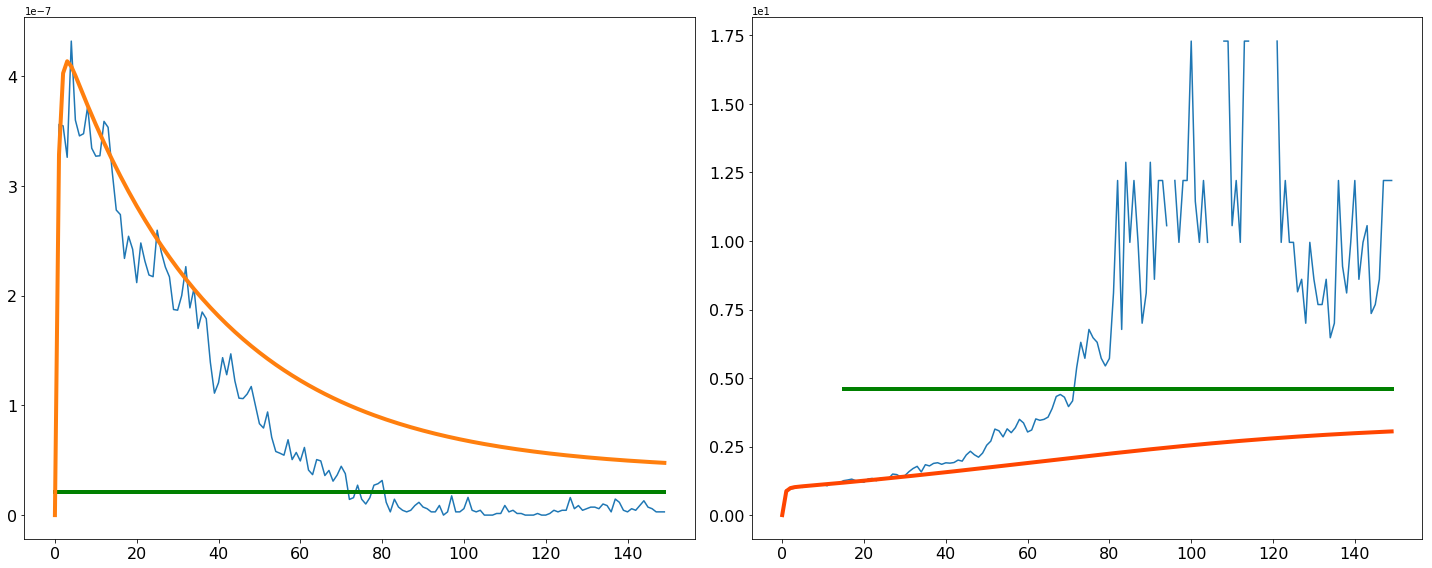

In [173]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.plot(range(T), np.var(simulations/1501, axis = 0)[:500], label = 'Numerical simulations')
# plt.plot(ts, P[:,8]/1500, label = 'Variance') 
plt.plot(range(T), np.maximum(quasip, 0), c= 'green', linewidth = 4)
plt.plot(range(T), varIp/1501, linewidth = 4)
# plt.plot([t_star, t_star], [0,4e-6], '--', label = '$R_0 = 1$')
# plt.plot(ts, -Q[:,3], label = '2nd')
# plt.plot(ts, (np.sqrt(P[:,8])/P[:,2]))
# plt.legend(fontsize = 16)
# plt.legend(fontsize =20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
# plt.ylim([0,0.4e-6])
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.subplot(1,2,2)
plt.plot(range(T), variation(simulations[:,0:500]/N, axis = 0), label = 'Numerical simulations')
# plt.plot(ts, np.sqrt(P[:,8]/N)/P[:,2], label = 'Coef of \n variation') 
plt.plot(range(T)[15:], quasi_covp[15:], c = 'green', linewidth = 4)
plt.plot(time, np.sqrt(varIp/1501)/meanIp, c = 'orangered', linewidth = 4)
# plt.plot([t_star, t_star], [0, 3], '--', label = '$R_0 = 1$')
# plt.plot(ts, -Q[:,3], label = '2nd')
# plt.plot(ts, (np.sqrt(P[:,8])/P[:,2]))
# plt.legend()
# plt.legend(fontsize =20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
# plt.xlim([0,150])
# plt.ylim([0,1])
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

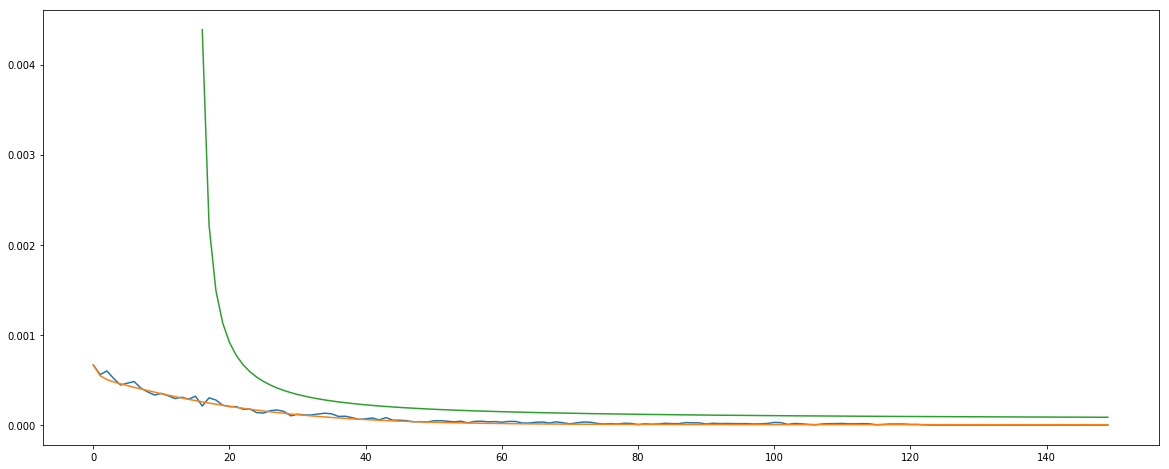

In [89]:
plt.figure(figsize = (20,8))
plt.plot(range(T), np.mean(simulations/1500, axis = 0))
plt.plot(range(T), meanIp)
plt.plot(range(T)[16:], m[16:])


In [670]:
m*1500

[5.4357203996011016e-05,
 5.4279426760258764e-05,
 5.420172365885058e-05,
 5.4124095128340927e-05,
 5.40465416028212e-05,
 5.3969063513905104e-05,
 5.389166129071417e-05,
 5.381433535986391e-05,
 5.3737086145449895e-05,
 5.3659914069034116e-05,
 5.3582819549631734e-05,
 5.350580300369793e-05,
 5.3428864845115e-05,
 5.3352005485179754e-05,
 5.327522533259124e-05,
 5.3198524793438545e-05,
 5.312190427118886e-05,
 5.304536416667609e-05,
 5.296890487808909e-05,
 5.2892526800961036e-05,
 5.2816230328158067e-05,
 5.274001584986895e-05,
 5.266388375359459e-05,
 5.258783442413792e-05,
 5.2511868243594065e-05,
 5.243598559134066e-05,
 5.2360186844028436e-05,
 5.228447237557222e-05,
 5.220884255714193e-05,
 5.2133297757154006e-05,
 5.2057838341263014e-05,
 5.1982464672353504e-05,
 5.1907177110532216e-05,
 5.1831976013120346e-05,
 5.175686173464622e-05,
 5.168183462683816e-05,
 5.160689503861761e-05,
 5.153204331609252e-05,
 5.1457279802550845e-05,
 5.1382604838454654e-05,
 5.130801876143396e-05,

In [168]:
np.matrix.getH(l)


matrix([[1, 0, 1],
        [2, 4, 0],
        [3, 5, 6]])